In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

! pip install category_encoders
from category_encoders.cat_boost import CatBoostEncoder
import lightgbm as lgb
from lightgbm import LGBMModel, LGBMRegressor

     |████████████████████████████████| 81kB 2.4MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/test.csv")

In [ ]:
train_x = train.drop(['price'], axis = 1)
train_y = train.loc[:, ['price']]
test_x = test.drop(['price'], axis = 1)
test_y = np.sqrt(test.loc[:, ['price']])


feature_list = list(train_x.columns)

CBE_encoder = CatBoostEncoder()
train_cbe = CBE_encoder.fit_transform(train_x[feature_list], train_y)
test_cbe = CBE_encoder.transform(test_x[feature_list])

best_lgbm_reg = LGBMRegressor(learning_rate = 0.3)
best_lgbm_reg.fit(train_cbe, train_y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.3, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
# 1.1 모델 불러오기

import pickle
import joblib

#import pickle model

model_lgbm = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/lgbm.pkl', 'rb'))
print(model_lgbm)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.3, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


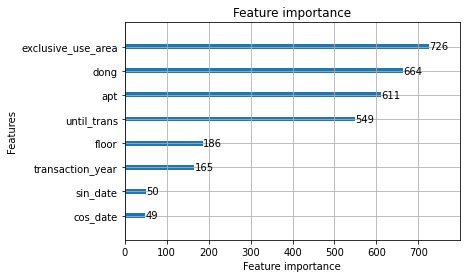

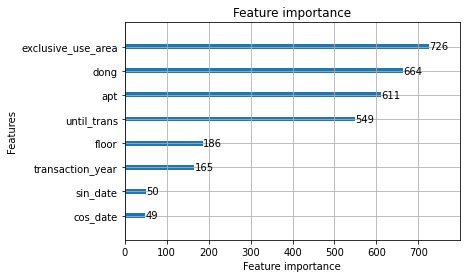

In [ ]:
# 1.2 Feature Importance 확인과 해석

from lightgbm import plot_importance

plot_importance(model_lgbm)
plot_importance(best_lgbm_reg)

In [ ]:
'''상단의 그래프는 주어졌던 lgbm.pkl 모델의 변수 중요도를 나타낸 그래프이고, 하단은 learning_rate 하이퍼 파라미터를 0,3으로 설정해 train, test data에 적합시킨 lgbm 모델의 변수 중요도를 나타낸 그래프입니다. 두 모델의 변수 중요도가 동일하게 나옵니다. exclusive_use_area 변수의 중요도가 가장 높고, sin, cos_date 변수들의 중요도가 가장 낮은 것으로 나타납니다. 그러나 plot_importance 함수에 의해 출력되는 변수 중요도는 트리가 분할할 때 정보 획득이나 불순도 감소만을 고려하여 계산된 중요도이기 때문에 이 결과를 두고 변수를 마음대로 삭제해선 안 될 것입니다.'''


'상단의 그래프는 주어졌던 lgbm.pkl 모델의 변수 중요도를 나타낸 그래프이고, 하단은 learning_rate 하이퍼 파라미터를 0,3으로 설정해 train, test data에 적합시킨 lgbm 모델의 변수 중요도를 나타낸 그래프입니다. 두 모델의 변수 중요도가 동일하게 나옵니다. exclusive_use_area 변수의 중요도가 가장 높고, sin, cos_date 변수들의 중요도가 가장 낮은 것으로 나타납니다. 그러나 plot_importance 함수에 의해 출력되는 변수 중요도는 트리가 분할할 때 정보 획득이나 불순도 감소만을 고려하여 계산된 중요도이기 때문에 이 결과를 두고 변수를 마음대로 삭제해선 안 될 것입니다.'

In [ ]:
#1.3 Randomness Control

import random
import os

# define seed setting function

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

seed = 42
seed_everything(seed)

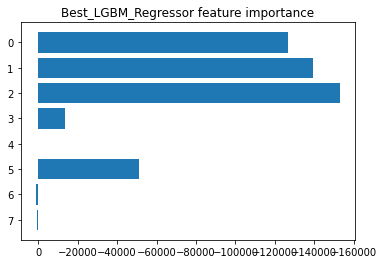

In [ ]:
# 1.4 permutation feature importance

from sklearn.inspection import permutation_importance


# Get permutation importance 

feature_importance = permutation_importance(best_lgbm_reg, test_cbe, test_y)
plt.figure()
plt.title("Best_LGBM_Regressor feature importance")
plt.barh(range(len(feature_importance.importances)),feature_importance['importances_mean'])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# 1.5 SHAP의 확인과 해석

! pip install shap
import shap

     |████████████████████████████████| 358kB 3.8MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491630 sha256=8e1ee72191d7a1636b89b47f0502e90a24e0e4f6ac21e63103c2be18f54762a9
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [ ]:
explainer = shap.TreeExplainer(best_lgbm_reg)
shap_values = explainer.shap_values(test_cbe)
print(shap_values)

[[ 14788.18429795  24825.40073017 -17308.60514861 ...  -2381.6792384
    -101.93093932   -748.65682123]
 [ 18546.35124824  27280.57485462  -1868.86578815 ...  -2658.71306596
    -727.73322834   -311.10006452]
 [ 32768.56804111  31570.7803186   39978.26540313 ...    340.35862229
   -1409.02416037   -227.87711933]
 ...
 [  -621.98184516  -3113.25390417   1605.7493677  ...    -85.40419241
     135.27340872    426.43454806]
 [  -666.69066725  -2945.48104078   1581.2657652  ...   -123.79420829
     134.01382241    425.69707863]
 [   727.64307015   2351.46325018   1979.80208876 ...    821.29790799
     133.12258368    423.5019585 ]]


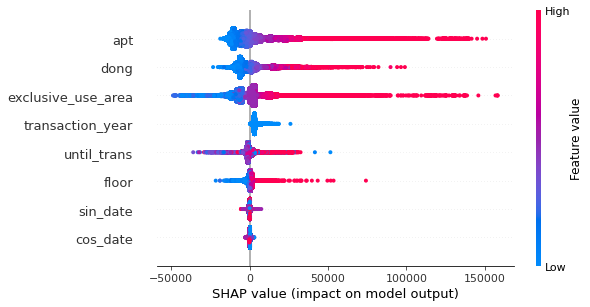

In [ ]:
shap.summary_plot(shap_values, test_cbe)

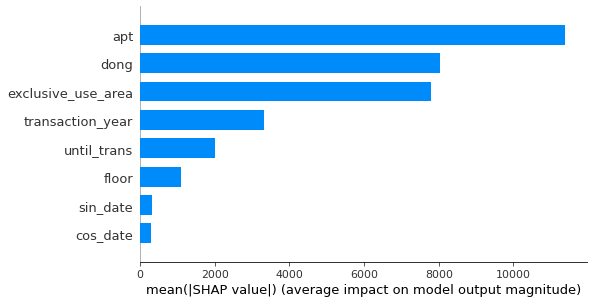

In [ ]:
shap.summary_plot(shap_values, test_cbe, plot_type = "bar")

In [ ]:
'''SHAP value는 Feature importance의 한계를 어느정도 극복할 수 있는 지표인 것 같은데, 실제 값과 예측 값의 평균적인 차이를 보여주기 때문에 feature importance보다 consistency가 높다고 볼 수 있을 것 같습니다. 상단 그래프는 shap value를 보여준 것이고 아래 그래프는 shap value의 절대값으로, 변수의 중요도를 표현해보려 했습니다. shap value는 feature importance와 다르게 상관관계의 방향까지 보여줍니다. 이를 바탕으로 해석을 해보면 apt, dong, exclusive_area 등의 변수는 그 값이 커질수록 집 가격이 높아짐을 알 수 있고 sin_date, cos_date는 별 영향을 미치지 않으며 until_trans 같은 경우는 postiive나 negative하게 영향을 미치는 크기가 거의 비슷합니다. 아래는 어떤 변수가 다른 변수들보다 평균적으로 크게 영향을 미치는지를 파악하는 정도로 보면 됩니다. 역시 apt, dong, exclusive_use_area 변수가 다른 변수들보다 영향력이 큽니다.'''

'SHAP value는 Feature importance의 한계를 어느정도 극복할 수 있는 지표인 것 같은데, 실제 값과 예측 값의 평균적인 차이를 보여주기 때문에 feature importance보다 consistency가 높다고 볼 수 있을 것 같습니다. 상단 그래프는 shap value를 보여준 것이고 아래 그래프는 shap value의 절대값으로, 변수의 중요도를 표현해보려 했습니다. shap value는 feature importance와 다르게 상관관계의 방향까지 보여줍니다. 이를 바탕으로 해석을 해보면 apt, dong, exclusive_area 등의 변수는 그 값이 커질수록 집 가격이 높아짐을 알 수 있고 sin_date, cos_date는 별 영향을 미치지 않으며 until_trans 같은 경우는 postiive나 negative하게 영향을 미치는 크기가 거의 비슷합니다. 아래는 어떤 변수가 다른 변수들보다 평균적으로 크게 영향을 미치는지를 파악하는 정도로 보면 됩니다. 역시 apt, dong, exclusive_use_area 변수가 다른 변수들보다 영향력이 큽니다.'

In [ ]:
! pip install tensorflow
import tensorflow as tf
import keras

from keras import models
from keras import layers
from keras.layers import Dense
from keras.optimizers import Adam

In [ ]:
#@title 2.1 주어진 코드를 실행하고, 현재 신경망의 구조에 대해 간단히 설명해주세요.


In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train.csv")
train_x = train.drop(['price'], axis = 1)
train_y = train.loc[:, ['price']]

val_x = train_x[train['transaction_year'] == 4]
val_y = train_y[train['transaction_year'] == 4]
train_tune_x = train_x[train['transaction_year'] < 4]
train_tune_y = train_y[train['transaction_year'] < 4]

CBE_encoder = CatBoostEncoder()
train_tune_cbe = CBE_encoder.fit_transform(train_tune_x[feature_list], train_tune_y)
val_cbe = CBE_encoder.transform(val_x[feature_list])

In [ ]:
def build_model():
  model = keras.Sequential([
    layers.Dense(256, activation = 'relu', input_shape = [len(train_cbe.keys())]),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(32, activation = 'relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.0001)

  model.compile(loss = 'mse', 
                optimizer = optimizer,
                metrics = ['mse'])
  return model



In [ ]:
model = build_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 256)               2304      
_________________________________________________________________
dense_17 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_18 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 33        
Total params: 20,865
Trainable params: 20,865
Non-trainable params: 0
_________________________________________________________________


In [ ]:
'''Keras 라이브러리의 Sequential 모델을 사용합니다. x배열의 데이터가 8개(# of variables)이므로 입력차원을 len(train_cbe.keys()) = 8로 지정합니다. 그 다음 시퀀스 오브젝트 모델에 64개의 Node를 Dense레이어를 통해 연결해줍니다. 이후 64개 Node, 32개 Node, 1개 Node를 가진 layer를 추가해 모델을 학습합니다. 총 4개의 레이어를 가진 신경망이 만들어집니다. 모델 평가는 MSE로 하고 모델 업데이트 옵티마이저는 RMSprop을 사용합니다.'''

'Keras 라이브러리의 Sequential 모델을 사용합니다. x배열의 데이터가 8개(# of variables)이므로 입력차원을 len(train_cbe.keys()) = 8로 지정합니다. 그 다음 시퀀스 오브젝트 모델에 64개의 Node를 Dense레이어를 통해 연결해줍니다. 이후 64개 Node, 32개 Node, 1개 Node를 가진 layer를 추가해 모델을 학습합니다. 총 4개의 레이어를 가진 신경망이 만들어집니다. 모델 평가는 MSE로 하고 모델 업데이트 옵티마이저는 RMSprop을 사용합니다.'

In [ ]:
history = model.fit(train_tune_cbe, train_tune_y, epochs=300, validation_data = (val_cbe, val_y), batch_size = 512)

Epoch 1/300
611/611 [==============================] - 4s 6ms/step - loss: 1073999994.9281 - mse: 1073999994.9281 - val_loss: 343586016.0000 - val_mse: 343586016.0000
Epoch 2/300
611/611 [==============================] - 3s 5ms/step - loss: 235852517.7778 - mse: 235852517.7778 - val_loss: 347230560.0000 - val_mse: 347230560.0000
Epoch 3/300
611/611 [==============================] - 3s 5ms/step - loss: 239222745.5948 - mse: 239222745.5948 - val_loss: 338309280.0000 - val_mse: 338309280.0000
Epoch 4/300
611/611 [==============================] - 4s 6ms/step - loss: 232658495.4510 - mse: 232658495.4510 - val_loss: 334979808.0000 - val_mse: 334979808.0000
Epoch 5/300
611/611 [==============================] - 3s 5ms/step - loss: 233537390.4575 - mse: 233537390.4575 - val_loss: 354656160.0000 - val_mse: 354656160.0000
Epoch 6/300
611/611 [==============================] - 3s 6ms/step - loss: 235608808.0523 - mse: 235608808.0523 - val_loss: 331326272.0000 - val_mse: 331326272.0000
Epoch 7/

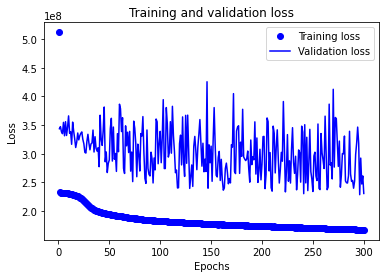

In [ ]:
mse = history.history['mse']
training_loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, len(mse) + 1)

plt.plot(epochs, training_loss, 'bo', label='Training loss')

plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
'''validation loss가 lgbm에 비해서 너무나 높게 측정이 됩니다. 신경망의 깊이가 얕았거나,, 다른 파라미터들의 조정이 잘 안 된 것 같은데 파라미터 공부를 더 해봐야 정확히 알 것 같습니다.'''

In [ ]:
feature_list = list(train_x.columns)

CBE_encoder = CatBoostEncoder()
train_cbe = CBE_encoder.fit_transform(train_x[feature_list], train_y)
test_cbe = CBE_encoder.transform(test_x[feature_list])

In [ ]:
def build_model():
  model = keras.Sequential([
    layers.Dense(1024, activation = 'relu', input_shape = [len(train_cbe.keys())]),
    layers.Dense(246, activation = 'relu'),
    layers.Dense(32, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.0001)

  model.compile(loss = 'mse', 
                optimizer = optimizer,
                metrics = ['mse'])
  return model


In [ ]:
model2 = build_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 256)               2304      
_________________________________________________________________
dense_17 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_18 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 33        
Total params: 20,865
Trainable params: 20,865
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model2.fit(test_cbe, test_y, epochs=300, batch_size = 512)

Epoch 1/300
179/179 [==============================] - 4s 24ms/step - loss: 5495819776.0000 - mse: 5495819776.0000
Epoch 2/300
179/179 [==============================] - 4s 24ms/step - loss: 5495819776.0000 - mse: 5495819776.0000
Epoch 3/300
179/179 [==============================] - 4s 24ms/step - loss: 5495820288.0000 - mse: 5495820288.0000
Epoch 4/300
179/179 [==============================] - 4s 25ms/step - loss: 5495818240.0000 - mse: 5495818240.0000
Epoch 5/300
179/179 [==============================] - 4s 24ms/step - loss: 5495820800.0000 - mse: 5495820800.0000
Epoch 6/300
179/179 [==============================] - 4s 25ms/step - loss: 5495819776.0000 - mse: 5495819776.0000
Epoch 7/300
179/179 [==============================] - 4s 24ms/step - loss: 5495818752.0000 - mse: 5495818752.0000
Epoch 8/300
179/179 [==============================] - 4s 25ms/step - loss: 5495819776.0000 - mse: 5495819776.0000
Epoch 9/300
179/179 [==============================] - 4s 25ms/step - loss: 5495

KeyboardInterrupt: ignored

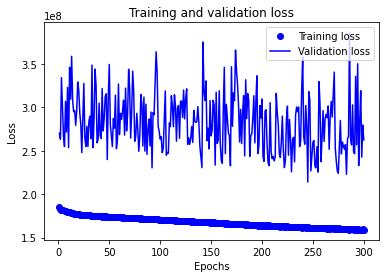

In [ ]:
mse = history.history['mse']
training_loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, len(mse) + 1)

plt.plot(epochs, training_loss, 'bo', label='Training loss')

plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
'''아직도 validation mse가 너무 높다,,, 다른 조합으로 시도'''